In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [78]:
df = pd.read_csv('heart_failure/train_val_split.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [79]:
def plot_binning(series, bins=10, name='data'):
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title('Histogram of ' + name)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()
    
def create_bar_plot(names, values):
    plt.bar(names, values)
    plt.xlabel('Names')
    plt.ylabel('Values')
    plt.title('Bar Plot')
    plt.xticks(rotation=90)
    plt.show()
    
def standardize_data(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data


    
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
nummeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [116]:
def create_dataloaders_from_arrays(X_train, y_train, X_test, y_test, batch_size=64):
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create TensorDatasets
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(model, train_loader, test_loader, device='cpu', epochs=10):
    # Move model to the device
    
    if not (device == 'cpu'):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            # Move data and target to the device
            target = target.view(-1, 1)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        # Print training statistics 
        train_loss = train_loss/len(train_loader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        
def make_predictions(model, array):
    # Convert the array to a PyTorch tensor
    tensor = torch.from_numpy(array).float()

    # Use the model to make predictions
    output = model(tensor)

    # Convert the output to probabilities using the sigmoid function
    probabilities = torch.sigmoid(output).detach().numpy()

    return probabilities

Data Visualization and Preprocessing

In [81]:
df['Sex'] = pd.factorize(df['Sex'])[0]
df['ChestPainType'] = pd.factorize(df['ChestPainType'])[0]
df['RestingECG'] = pd.factorize(df['RestingECG'])[0]
df['ExerciseAngina'] = pd.factorize(df['ExerciseAngina'])[0]
df['ST_Slope'] = pd.factorize(df['ST_Slope'])[0]

In [82]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,37,0,0,130,283,0,1,98,0,0.0,0,0
2,48,1,1,138,214,0,0,108,1,1.5,1,1
3,54,0,2,150,195,0,0,122,0,0.0,0,0
4,39,0,2,120,339,0,0,170,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,0,0,120,157,0,0,182,0,0.0,0,0
730,57,1,1,140,241,0,0,123,1,0.2,1,1
731,45,0,3,110,264,0,0,132,0,1.2,1,1
732,68,0,1,144,193,1,0,141,0,3.4,1,1


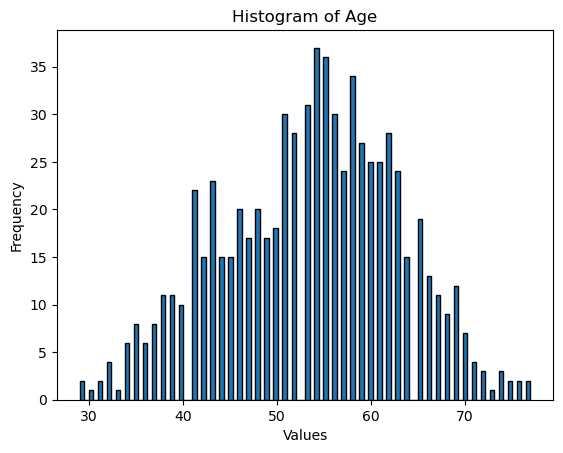

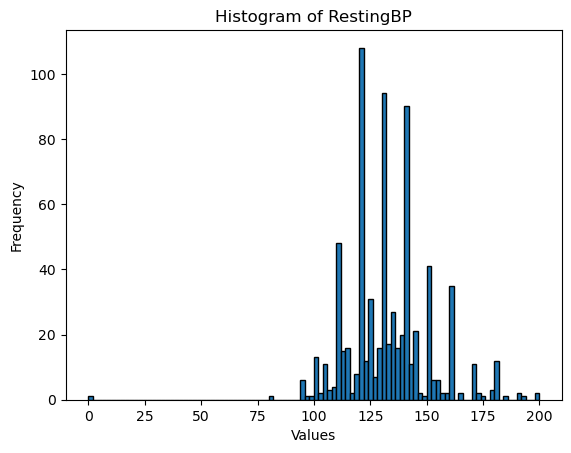

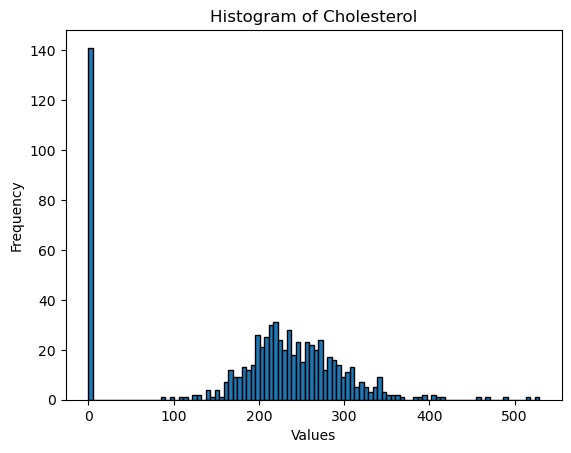

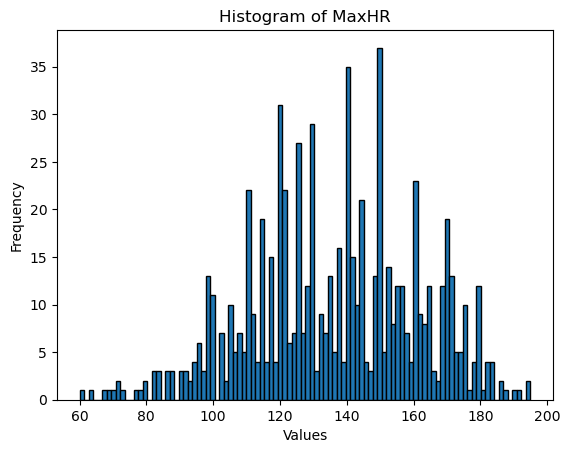

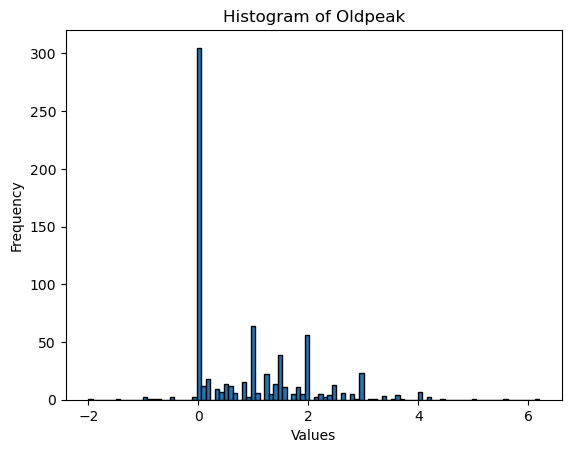

In [83]:
for col in nummeric:
    plot_binning(df[col], bins=100, name=col)

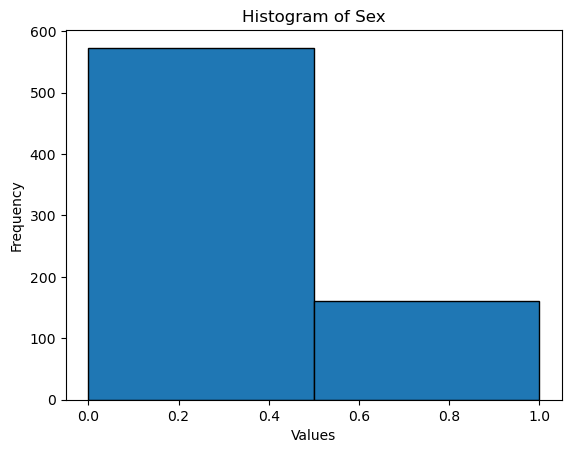

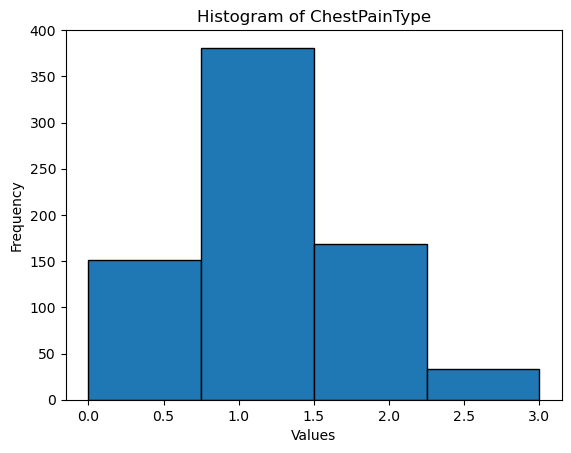

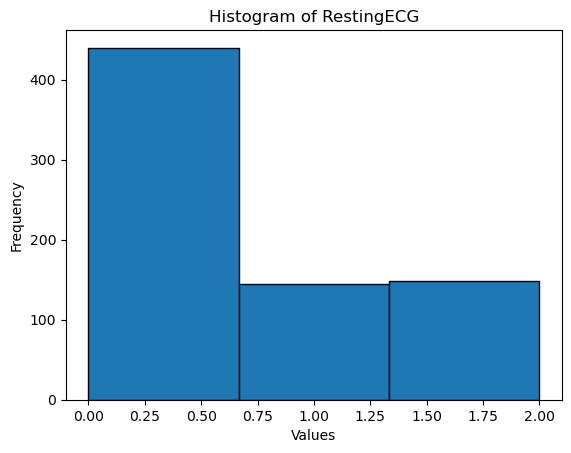

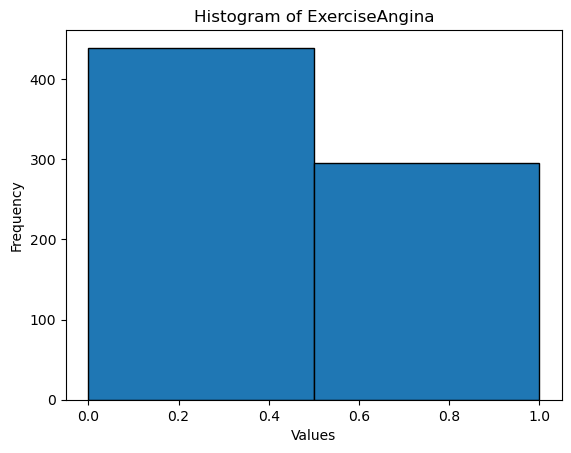

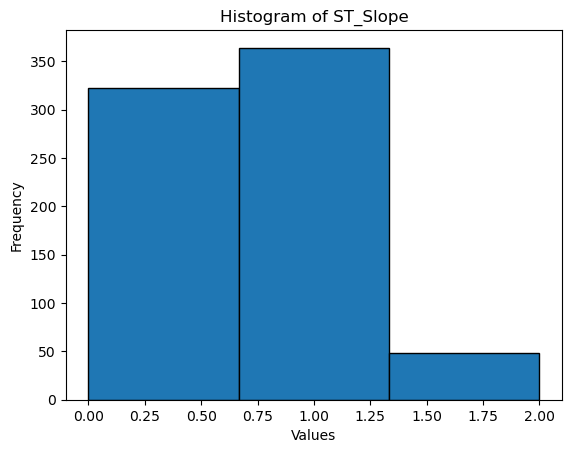

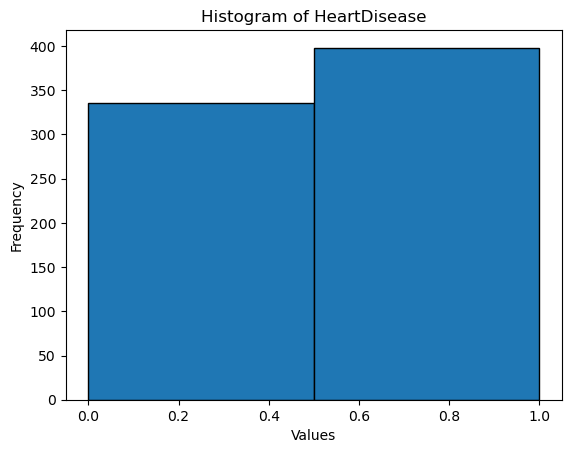

In [84]:
for col in categorical:
    plot_binning(df[col], bins=len(df[col].unique()), name=col)

In [85]:
X = df.drop(columns=['HeartDisease']).values
y = df['HeartDisease'].values
X_st = standardize_data(X)
#print(X_st)
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.2, random_state=42)
type(X_train)

numpy.ndarray

Lasso Regression

In [86]:
reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)

In [87]:
reg.alpha_

0.016043208596650652

In [88]:
reg.score(X_test, y_test)

0.5031830498639663

In [89]:
pred = reg.predict(X_test).round()
f1Score = f1_score(y_test, pred)
bAccuracy = balanced_accuracy_score(y_test, pred)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.8831168831168831 balanced accuracy:  0.8769458858413639


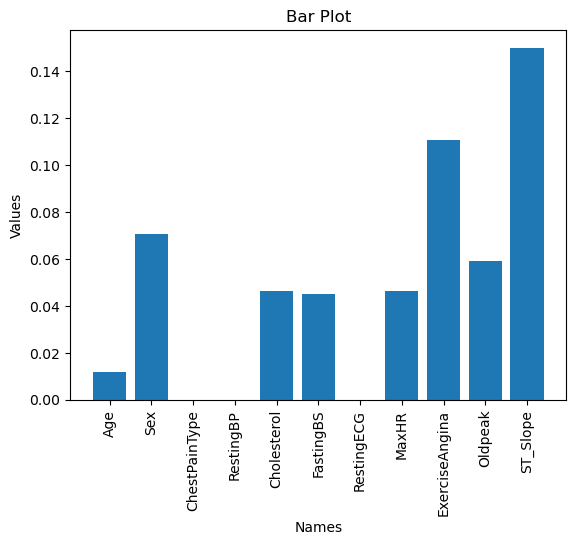

In [90]:
create_bar_plot(df.columns[0:11], np.abs(reg.coef_))

MLP

In [117]:
import tqdm
import copy
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        # print(epoch)
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [123]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(11, 10)
        #self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        #x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        #x = nn.functional.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x
    
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(11, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [124]:
train_loader, test_loader = create_dataloaders_from_arrays(X_train, y_train, X_test, y_test, batch_size=32)

In [125]:
(train_loader.dataset[0])

(tensor([-0.3742, -0.5301, -0.1474,  0.4266,  0.3068, -0.5511,  0.4935,  0.1514,
          1.2199,  3.8151,  0.6181]),
 tensor(1.))

In [126]:
model = MyModel()
train_model(model, train_loader, test_loader, device='cpu', epochs=100)

RuntimeError: all elements of input should be between 0 and 1

In [121]:
model.to('cpu')
preds = make_predictions(model, X_test)

In [98]:
preds = (preds * 2) - 1